[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [4]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [5]:
!nvidia-smi

Sat May 24 16:15:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [7]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 73.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [8]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-05-24 16:19:02--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K   480KB/s    in 0.2s    

2025-05-24 16:19:02 (480 KB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:00<00:00, 97.0MB/s]


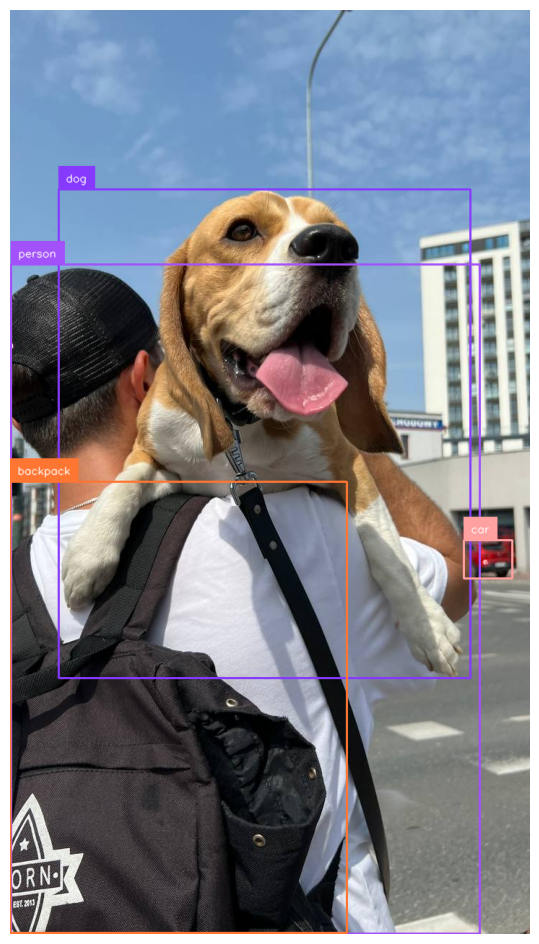

In [9]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [11]:
from roboflow import Roboflow
rf = Roboflow(api_key="CLVPWLuHbp6rCuEZkJpY")
project = rf.workspace("thesis-road-defect-detection").project("road-defects-2tvjx")
version = project.version(2)
dataset = version.download("yolov12")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Road-Defects-2 in yolov12:: 100%|██████████| 4890/4890 [00:01<00:00, 4776.64it/s]


In [12]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [14]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [15]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 6
names: ['Alligator crack', 'Longitudinal crack', 'Oblique crack', 'Pothole', 'Repair', 'Transverse crack']

roboflow:
  workspace: thesis-road-defect-detection
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [16]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.3.144 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/Road-Defects-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 

100%|██████████| 755k/755k [00:00<00:00, 35.8MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 134MB/s]


AMP: checks passed ✅


train: Scanning /content/Road-Defects-2/train/labels... 2140 images, 14 backgrounds, 0 corrupt: 100%|██████████| 2140/2140 [00:01<00:00, 1779.49it/s]


train: New cache created: /content/Road-Defects-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Road-Defects-2/valid/labels... 199 images, 1 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<00:00, 1180.95it/s]


val: New cache created: /content/Road-Defects-2/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.72G      4.915      5.267      3.973         86        640: 100%|██████████| 134/134 [01:18<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]

                   all        199        941   0.000323     0.0133   0.000212   8.32e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.82G      4.143      4.473      3.364         63        640: 100%|██████████| 134/134 [01:15<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]

                   all        199        941   0.000229    0.00622   0.000129   2.76e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.68G      3.674      3.779      2.971         52        640: 100%|██████████| 134/134 [01:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        199        941      0.514     0.0372     0.0108    0.00254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.83G      3.452      3.389      2.736         52        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]

                   all        199        941       0.52     0.0678     0.0151    0.00341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.83G      3.259      3.201      2.562         69        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        199        941      0.527     0.0483     0.0178    0.00457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.87G      3.079      3.067      2.426         80        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        199        941      0.368     0.0869     0.0267    0.00697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.83G      2.995      3.012      2.337         66        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


                   all        199        941      0.371     0.0762     0.0402     0.0114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.83G      2.893      2.914      2.247         52        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

                   all        199        941      0.548     0.0803     0.0417     0.0113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.85G      2.858      2.892      2.226         67        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        199        941      0.438     0.0941     0.0395     0.0109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.83G      2.804      2.876      2.198         55        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

                   all        199        941      0.407     0.0981     0.0424     0.0124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.85G      2.752      2.797      2.133         95        640: 100%|██████████| 134/134 [01:14<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

                   all        199        941       0.39     0.0816     0.0456     0.0125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.87G      2.717      2.784       2.12         85        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

                   all        199        941      0.405      0.118     0.0598     0.0176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.73G      2.675      2.726      2.091         51        640: 100%|██████████| 134/134 [01:14<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        199        941      0.271      0.118     0.0619     0.0184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.83G      2.662      2.699      2.065         85        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

                   all        199        941      0.277      0.132     0.0678     0.0214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.67G      2.641      2.672      2.044         55        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]

                   all        199        941      0.281      0.154     0.0731     0.0213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.82G      2.606      2.652      2.036         70        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        199        941      0.271       0.14      0.082     0.0241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       6.7G      2.596      2.609      2.012         65        640: 100%|██████████| 134/134 [01:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        199        941      0.296      0.159     0.0804     0.0248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.83G      2.559      2.587      1.998         54        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        199        941      0.296      0.166     0.0807     0.0255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.84G      2.567      2.538      1.979         75        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        199        941      0.321      0.184     0.0945     0.0286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.87G      2.538       2.55      1.966         95        640: 100%|██████████| 134/134 [01:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        199        941      0.315      0.212     0.0956     0.0298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.87G      2.514      2.537      1.948         55        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.33it/s]


                   all        199        941      0.302      0.175      0.109     0.0316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.86G      2.523      2.526       1.95        112        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]

                   all        199        941      0.315      0.173      0.109     0.0351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.67G      2.485      2.486      1.924         98        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]

                   all        199        941      0.327       0.19      0.116     0.0347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.84G       2.48      2.472      1.915         72        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]

                   all        199        941      0.344      0.201       0.13     0.0423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       6.7G      2.467      2.451      1.901         99        640: 100%|██████████| 134/134 [01:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all        199        941      0.311      0.195      0.123     0.0396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.85G      2.449      2.423      1.899         83        640: 100%|██████████| 134/134 [01:14<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        199        941      0.347      0.184      0.137     0.0477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.68G      2.443      2.448      1.889        101        640: 100%|██████████| 134/134 [01:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all        199        941      0.321      0.216       0.14      0.045



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.86G      2.427      2.433      1.877         63        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        199        941      0.357      0.225      0.141     0.0507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.72G      2.431      2.424      1.877         60        640: 100%|██████████| 134/134 [01:14<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        199        941      0.341      0.208       0.13     0.0461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.86G      2.418      2.396      1.865         92        640: 100%|██████████| 134/134 [01:14<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

                   all        199        941      0.354      0.214      0.136     0.0461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.68G      2.403      2.395      1.875         59        640: 100%|██████████| 134/134 [01:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

                   all        199        941      0.311      0.187      0.108      0.034



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.83G        2.4      2.386      1.847        104        640: 100%|██████████| 134/134 [01:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all        199        941      0.317      0.214      0.123      0.041



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.72G      2.403       2.38      1.848         97        640: 100%|██████████| 134/134 [01:14<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]

                   all        199        941      0.374      0.229      0.163     0.0568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.85G      2.388      2.344      1.836         70        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

                   all        199        941      0.351      0.217      0.145     0.0518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.66G      2.382      2.348       1.85         75        640: 100%|██████████| 134/134 [01:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

                   all        199        941      0.305      0.234      0.129     0.0396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.88G      2.381      2.361      1.844         74        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]

                   all        199        941      0.362      0.251      0.171     0.0585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.67G      2.366      2.337       1.82         74        640: 100%|██████████| 134/134 [01:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

                   all        199        941      0.375      0.234      0.158     0.0523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.83G      2.351      2.347      1.827         94        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]

                   all        199        941      0.354       0.26      0.155     0.0505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       6.7G      2.333      2.316      1.815         97        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

                   all        199        941       0.34       0.25      0.149     0.0482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.87G      2.337      2.297      1.808         53        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        199        941       0.39      0.276      0.196     0.0686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.83G      2.327      2.306      1.807         65        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        199        941       0.34      0.221      0.149     0.0481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.85G      2.329      2.302      1.807         61        640: 100%|██████████| 134/134 [01:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        199        941      0.384      0.246      0.186     0.0615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.83G      2.313      2.289      1.788         78        640: 100%|██████████| 134/134 [01:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        199        941      0.363      0.283       0.17     0.0575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.86G      2.325      2.293        1.8        117        640: 100%|██████████| 134/134 [01:14<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        199        941      0.351      0.254      0.164     0.0563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.85G      2.305       2.27       1.79         68        640: 100%|██████████| 134/134 [01:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


                   all        199        941      0.384      0.272      0.178     0.0597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.67G      2.323      2.279       1.79         84        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        199        941      0.335      0.258      0.139     0.0444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.85G      2.299      2.263      1.794         73        640: 100%|██████████| 134/134 [01:14<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


                   all        199        941      0.423      0.246      0.198     0.0645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.87G      2.296      2.239      1.777         55        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


                   all        199        941      0.361      0.266      0.194     0.0669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       6.7G      2.295      2.234      1.771         85        640: 100%|██████████| 134/134 [01:14<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        199        941      0.214      0.265      0.182     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.86G      2.289      2.243      1.782         99        640: 100%|██████████| 134/134 [01:14<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


                   all        199        941      0.373       0.28      0.192     0.0655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       6.7G      2.262      2.212      1.756         74        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        199        941       0.36      0.322      0.206     0.0687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.85G      2.282      2.246      1.771         97        640: 100%|██████████| 134/134 [01:14<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        199        941        0.2      0.275      0.165     0.0541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.71G      2.249      2.201      1.753         88        640: 100%|██████████| 134/134 [01:14<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        199        941      0.344      0.246      0.175     0.0579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.86G      2.268      2.195      1.755         40        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        199        941      0.415      0.271      0.214     0.0732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.68G      2.267       2.21      1.755         49        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        199        941      0.412      0.283      0.202     0.0696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.85G      2.249        2.2      1.752         84        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        199        941      0.246      0.274      0.212     0.0729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.87G      2.245      2.184      1.738         87        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


                   all        199        941      0.393      0.269      0.188     0.0652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.84G      2.244      2.186      1.742         77        640: 100%|██████████| 134/134 [01:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


                   all        199        941      0.208      0.322      0.197     0.0693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.87G      2.244      2.167      1.741         58        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


                   all        199        941      0.264      0.292      0.221     0.0791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.85G       2.23      2.161      1.732         85        640: 100%|██████████| 134/134 [01:14<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


                   all        199        941      0.431      0.274      0.211     0.0746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.85G      2.233       2.18       1.73         42        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        199        941       0.24      0.264      0.199     0.0697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.86G      2.224      2.157      1.721         66        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        199        941      0.238      0.292      0.223     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.71G      2.224      2.152      1.725        106        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


                   all        199        941       0.39      0.287      0.206     0.0755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       6.7G      2.228      2.137      1.719         71        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        199        941      0.199      0.259      0.184      0.059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.68G      2.204       2.14      1.709         51        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        199        941      0.238      0.281       0.21     0.0696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.83G      2.198      2.133      1.722         92        640: 100%|██████████| 134/134 [01:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        199        941      0.251      0.281      0.222     0.0786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.71G        2.2       2.14      1.709         55        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        199        941      0.225      0.304      0.209     0.0758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.68G      2.188      2.115      1.706         53        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


                   all        199        941      0.226      0.326       0.23     0.0826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.86G      2.186      2.102      1.703         93        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


                   all        199        941      0.211      0.303      0.223     0.0767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.68G      2.183      2.112      1.698         90        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


                   all        199        941      0.385      0.251      0.204     0.0698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.84G      2.197      2.111      1.716         87        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        199        941      0.324      0.286      0.232     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.68G        2.2      2.104       1.69         92        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


                   all        199        941      0.243       0.28      0.221     0.0787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.87G      2.174      2.083      1.687         93        640: 100%|██████████| 134/134 [01:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


                   all        199        941      0.254      0.327      0.212     0.0747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.67G       2.17      2.092      1.683         54        640: 100%|██████████| 134/134 [01:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


                   all        199        941        0.4      0.306       0.22     0.0767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.86G      2.167      2.091      1.689         92        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


                   all        199        941       0.29      0.338      0.244     0.0925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       6.7G      2.158      2.083      1.685         89        640: 100%|██████████| 134/134 [01:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        199        941      0.339      0.304      0.249     0.0903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.86G      2.144      2.072      1.673         76        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


                   all        199        941      0.413       0.32      0.236     0.0871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.85G       2.16      2.068      1.682        104        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


                   all        199        941      0.263      0.287      0.231     0.0828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.86G      2.147      2.053      1.671         71        640: 100%|██████████| 134/134 [01:14<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


                   all        199        941      0.436      0.291       0.23     0.0853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.86G      2.132      2.037      1.669         95        640: 100%|██████████| 134/134 [01:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


                   all        199        941      0.262      0.291       0.24     0.0914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.85G       2.15      2.041      1.676         76        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

                   all        199        941      0.485      0.281      0.235     0.0829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.67G      2.138      2.052      1.677         73        640: 100%|██████████| 134/134 [01:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]

                   all        199        941      0.277      0.293      0.243     0.0903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.86G      2.139      2.036      1.671         79        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]

                   all        199        941      0.289      0.314      0.228     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.66G      2.126      2.039      1.665         77        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


                   all        199        941      0.377      0.331      0.264     0.0969

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.82G      2.137      2.035      1.656         91        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


                   all        199        941      0.269      0.346      0.233     0.0839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.85G      2.126      2.026      1.657         34        640: 100%|██████████| 134/134 [01:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


                   all        199        941      0.278      0.306      0.241      0.088

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.83G      2.135      2.025      1.656         75        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


                   all        199        941      0.265      0.325      0.249     0.0906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.82G       2.11      2.005      1.642        116        640: 100%|██████████| 134/134 [01:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


                   all        199        941      0.281        0.3      0.247     0.0901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.85G       2.11      2.007      1.644         44        640: 100%|██████████| 134/134 [01:14<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        199        941      0.265      0.312      0.237       0.09



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.85G      2.095      2.003      1.652         77        640: 100%|██████████| 134/134 [01:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

                   all        199        941      0.297      0.293       0.24     0.0878


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.86G      2.105      2.038      1.711         70        640: 100%|██████████| 134/134 [01:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        199        941       0.29      0.278      0.248     0.0913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.84G      2.088      1.995      1.691         56        640: 100%|██████████| 134/134 [01:12<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        199        941      0.268       0.31      0.243     0.0924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.85G      2.078      1.982      1.688         30        640: 100%|██████████| 134/134 [01:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


                   all        199        941      0.283      0.312      0.248     0.0956

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.83G      2.072      1.971      1.687         44        640: 100%|██████████| 134/134 [01:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


                   all        199        941      0.297       0.29      0.253     0.0972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.86G      2.067      1.975      1.679         45        640: 100%|██████████| 134/134 [01:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        199        941      0.308      0.313      0.265        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.68G      2.059      1.948      1.676         39        640: 100%|██████████| 134/134 [01:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


                   all        199        941      0.279      0.318      0.253     0.0984

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.87G      2.051      1.941      1.671         59        640: 100%|██████████| 134/134 [01:12<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


                   all        199        941      0.288       0.32      0.262     0.0984

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       6.7G      2.053      1.936      1.671         34        640: 100%|██████████| 134/134 [01:12<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


                   all        199        941      0.287      0.318      0.247     0.0937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.86G       2.04      1.926      1.657         43        640: 100%|██████████| 134/134 [01:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


                   all        199        941      0.294      0.309      0.256     0.0985

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.87G       2.05      1.924      1.665         52        640: 100%|██████████| 134/134 [01:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


                   all        199        941      0.295      0.314      0.254     0.0983

100 epochs completed in 2.178 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,076,530 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


                   all        199        941      0.309      0.314      0.264     0.0998
       Alligator crack         38         52      0.263      0.212      0.152     0.0429
    Longitudinal crack        100        273      0.461      0.498      0.374      0.134
         Oblique crack         66        148      0.379      0.257      0.238     0.0927
               Pothole          9         13          0          0     0.0294    0.00734
                Repair         16         26      0.281      0.423      0.355      0.153
      Transverse crack        176        429      0.471      0.494      0.439      0.169
Speed: 0.3ms preprocess, 9.2ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [17]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch12060.jpg
confusion_matrix_normalized.png			   train_batch12061.jpg
confusion_matrix.png				   train_batch12062.jpg
events.out.tfevents.1748103744.b1669a10a096.721.0  train_batch1.jpg
F1_curve.png					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


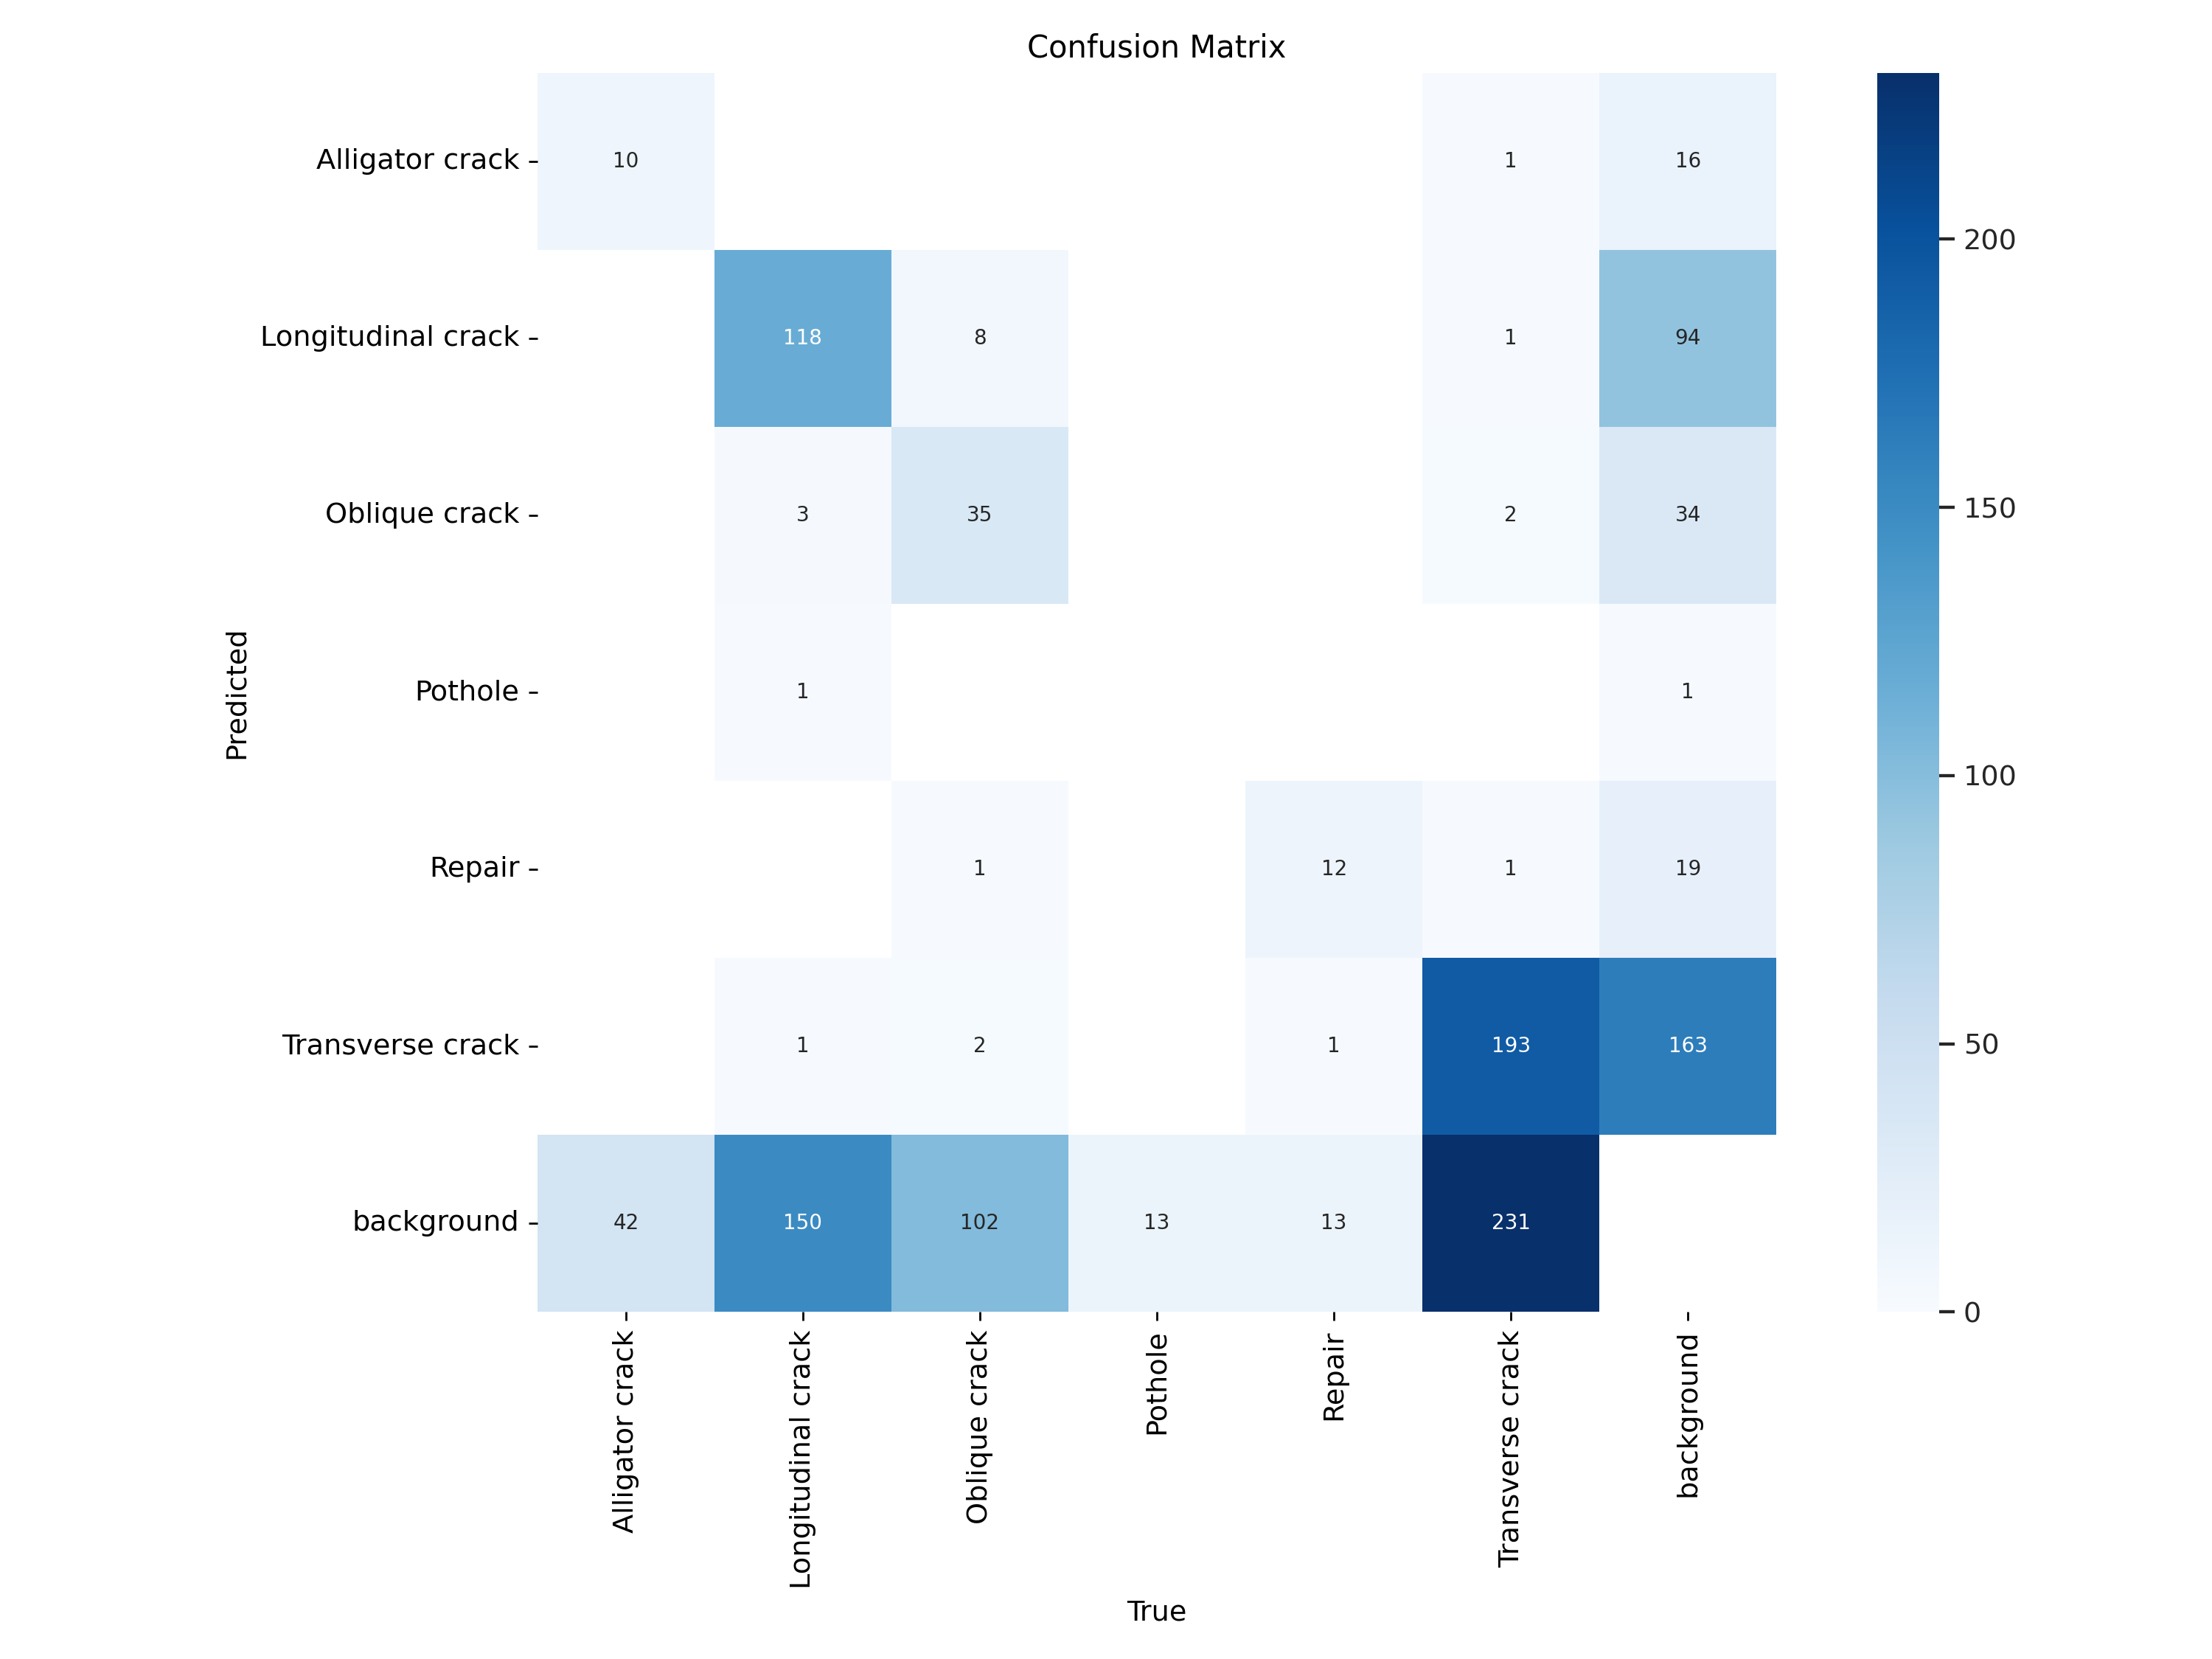

In [18]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

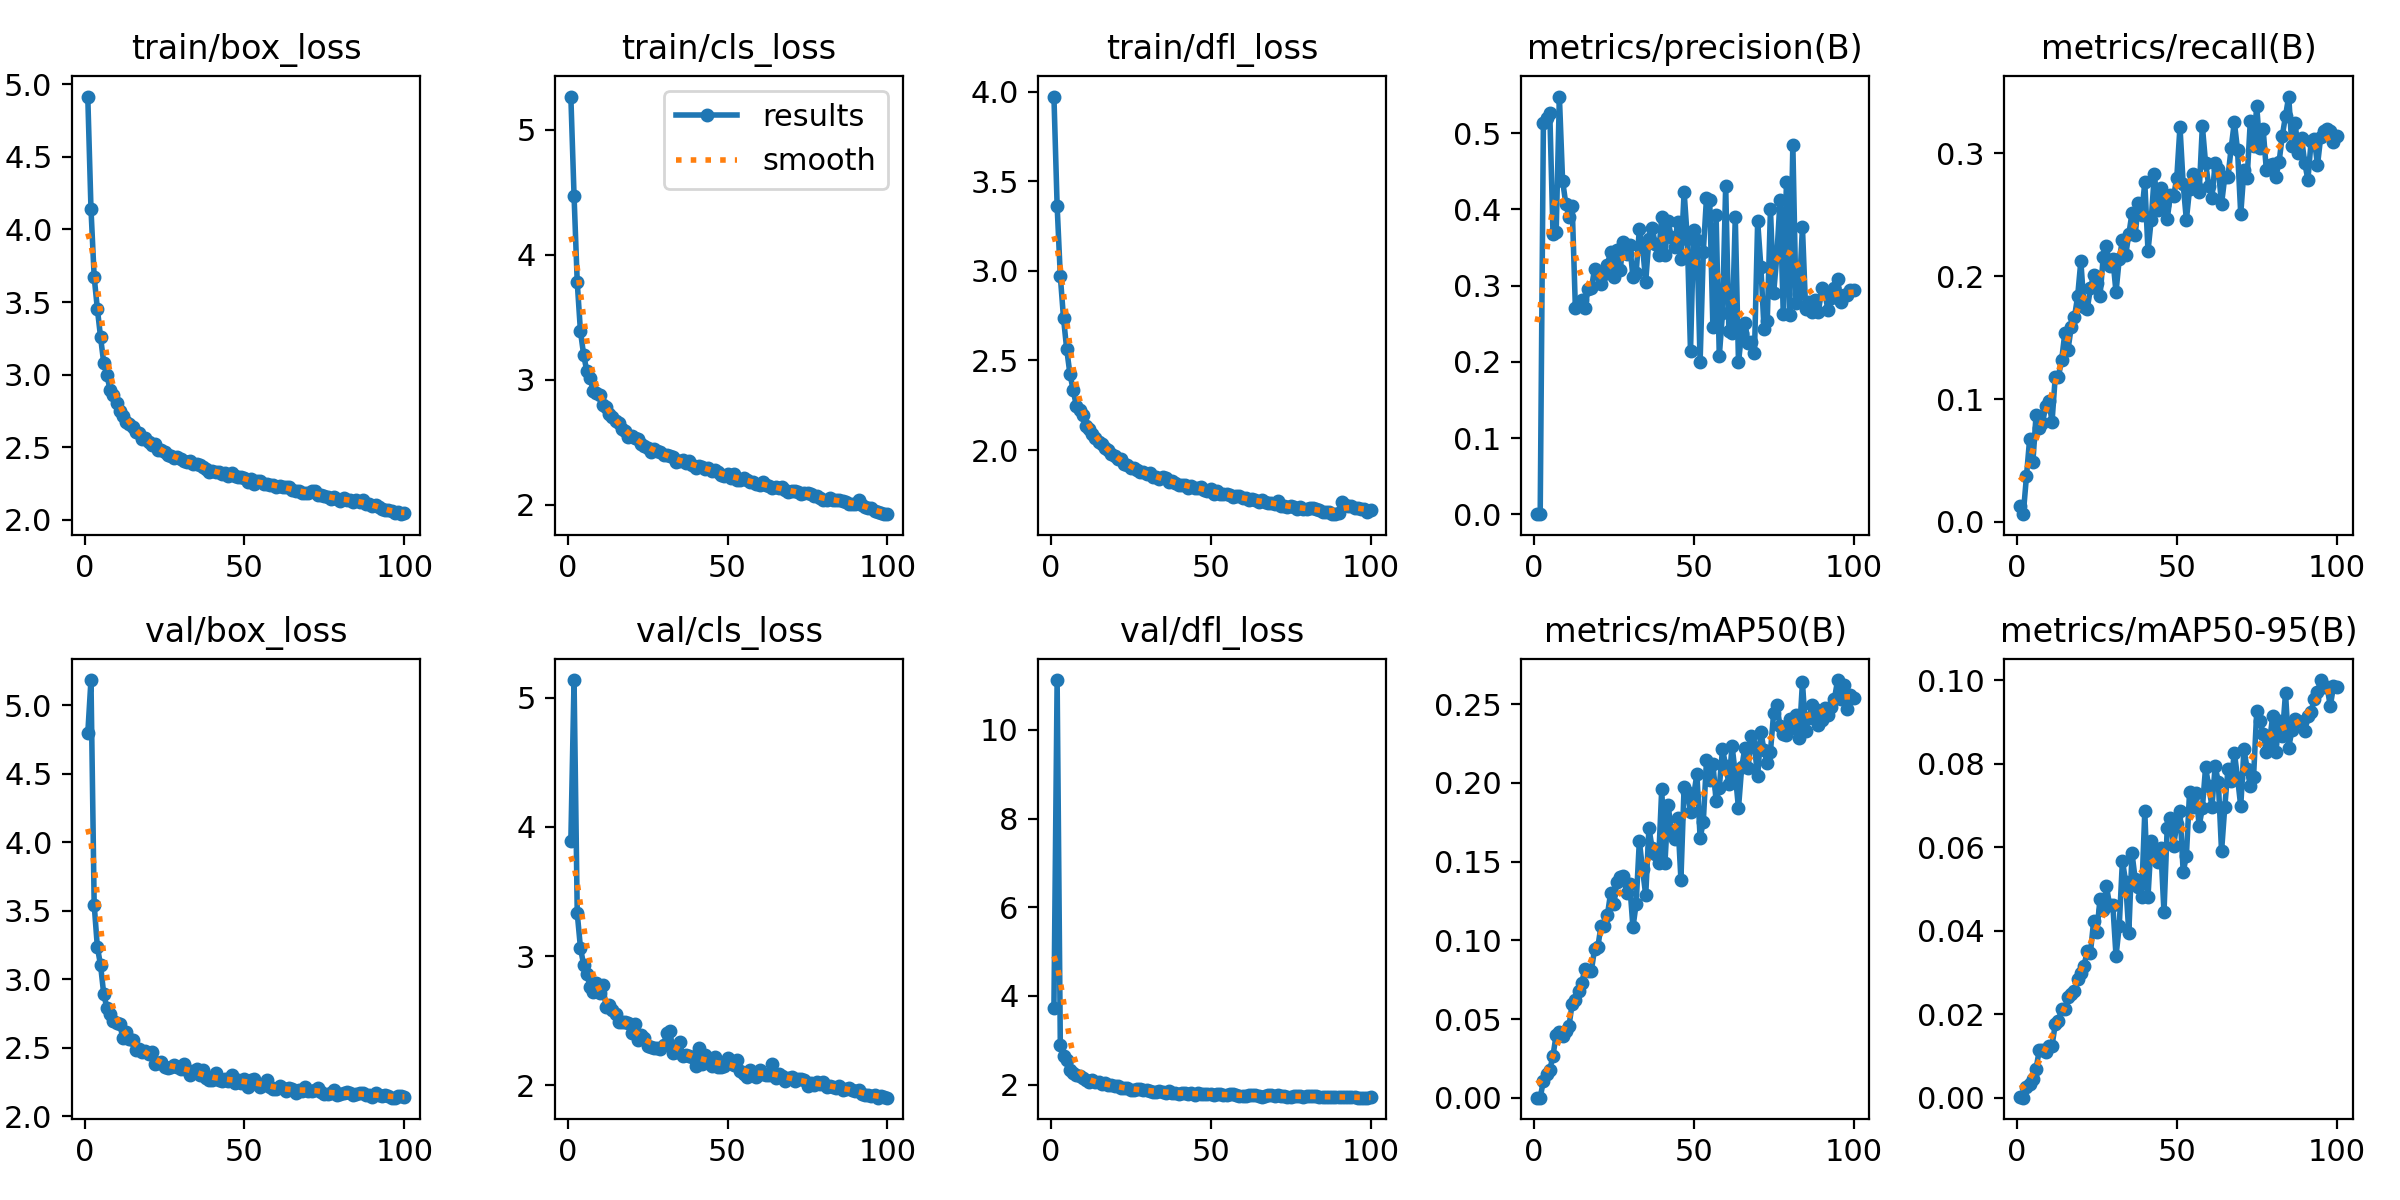

In [19]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [20]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Alligator crack',
 'Longitudinal crack',
 'Oblique crack',
 'Pothole',
 'Repair',
 'Transverse crack']

In [22]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [23]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.05911099344559025
mAP 50 0.1552101344662484
mAP 75 0.03246833391331211


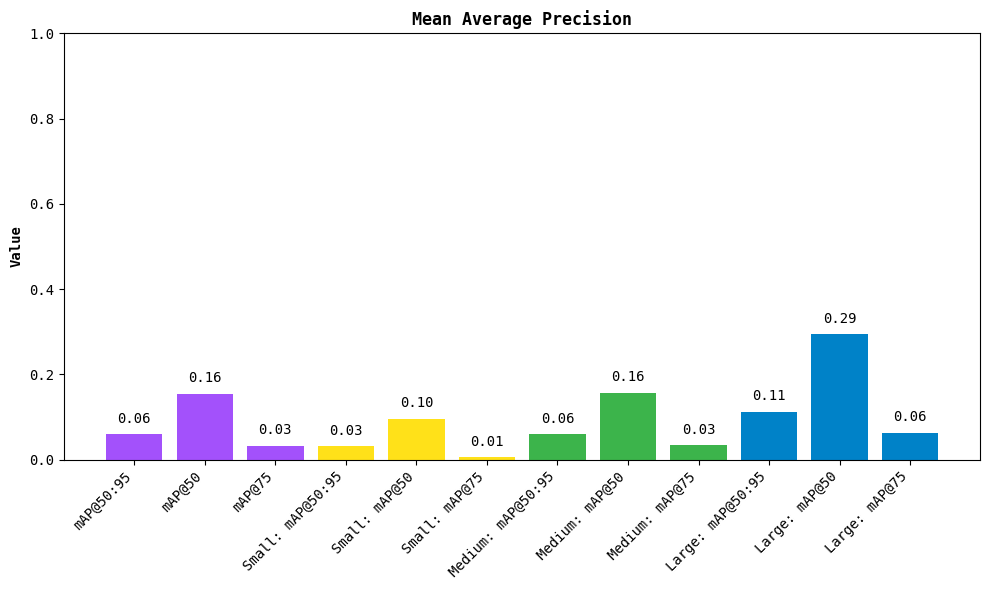

In [24]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [25]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

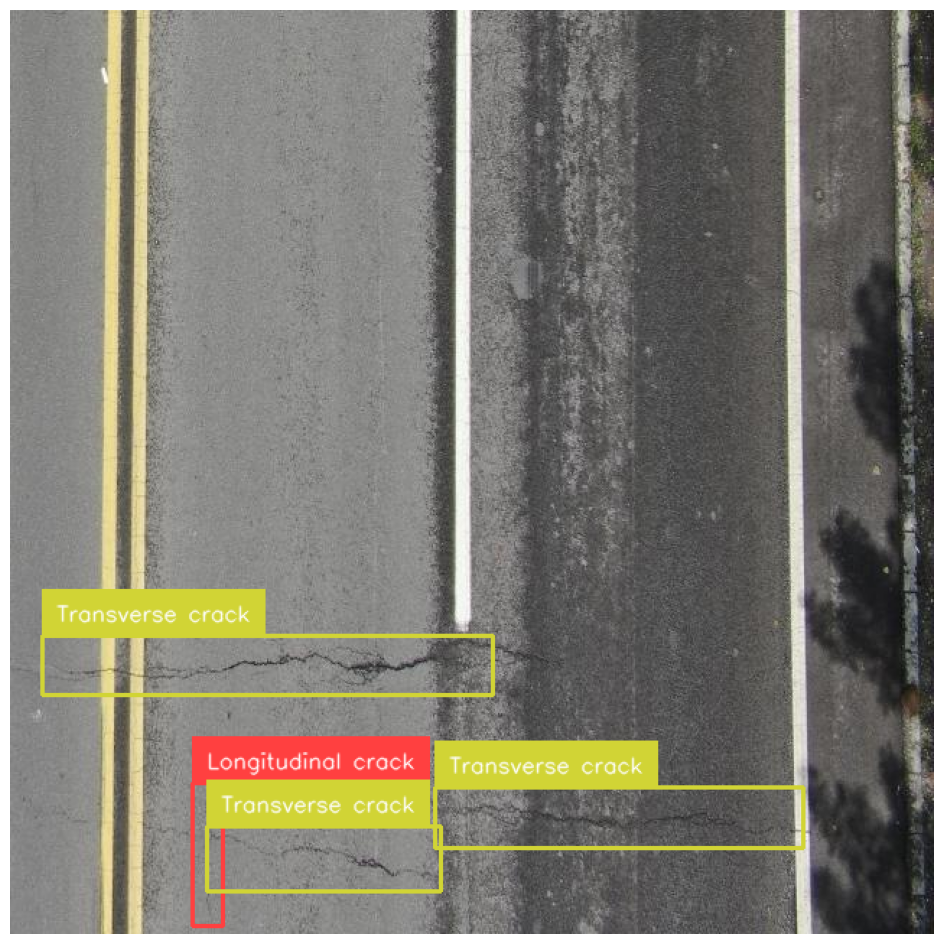

In [26]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

# ORTHO Interference

In [ ]:
# First install required geospatial libraries
!sudo apt-get install -y gdal-bin libgdal-dev
!pip install rasterio supervision ultralytics opencv-python-headless

import cv2
import numpy as np
import rasterio
from ultralytics import YOLO
import supervision as sv
import os
from rasterio.plot import reshape_as_image

# Configuration
HOME = os.getcwd()
INPUT_IMAGE_PATH = "/content/orhto.tif"
OUTPUT_IMAGE_PATH = "/content/annotated_orthophoto.tif"
TILE_SIZE = 100
MODEL_PATH = f'/{HOME}/runs/detect/train/weights/best.pt'
CONF_THRESH = 0.25

def process_orthophoto():
    # Load model
    model = YOLO(MODEL_PATH)

    # Load TIFF with rasterio
    with rasterio.open(INPUT_IMAGE_PATH) as src:
        # Read image data and convert to RGB format
        img = src.read()  # Reads as (bands, height, width)
        img = reshape_as_image(img)  # Converts to (height, width, bands)

        # Convert to BGR for OpenCV
        cv_image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        height, width = img.shape[:2]

        # Create annotators
        bounding_box_annotator = sv.BoundingBoxAnnotator()
        label_annotator = sv.LabelAnnotator()

        # Process tiles
        for y in range(0, height, TILE_SIZE):
            for x in range(0, width, TILE_SIZE):
                y_end = min(y + TILE_SIZE, height)
                x_end = min(x + TILE_SIZE, width)

                # Extract tile
                tile = img[y:y_end, x:x_end]

                # Run inference
                results = model(tile)[0]
                detections = sv.Detections.from_ultralytics(results)

                # Filter by confidence
                detections = detections[detections.confidence > CONF_THRESH]

                # Offset coordinates to original image space
                if len(detections.xyxy) > 0:
                    detections.xyxy += np.array([x, y, x, y])

                    # Annotate main image
                    cv_image = bounding_box_annotator.annotate(
                        scene=cv_image,
                        detections=detections
                    )
                    cv_image = label_annotator.annotate(
                        scene=cv_image,
                        detections=detections
                    )

        # Save result with geospatial information
        with rasterio.open(
            OUTPUT_IMAGE_PATH,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=3,
            dtype=cv_image.dtype,
            crs=src.crs,
            transform=src.transform,
        ) as dst:
            # Convert back to rasterio's band-first format
            dst.write(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB).transpose(2, 0, 1))

    print(f"Annotated geoTIFF saved to {OUTPUT_IMAGE_PATH}")

if __name__ == "__main__":
    process_orthophoto()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgdal-dev is already the newest version (3.6.4+dfsg-1~jammy0).
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,588 kB/5,055 kB of archives.
After this operation, 25.1 MB of additional disk space will be used.
Err:1 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.6.4+dfsg-1~jammy0
  404  Not Found [IP: 185.125.190.80 443]
Err:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.6.4+dfsg-1~jammy0
  404  Not Found [IP: 185.125.190.80 443]
E: Failed to fetch https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu/pool/main/g/gdal/python3-gdal_3.6.4%2bdfsg-

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Streaming output truncated to the last 5000 lines.

0: 640x640 (no detections), 26.9ms
Speed: 3.6ms preprocess, 26.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 24.9ms
Speed: 4.0ms preprocess, 24.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 29.6ms
Speed: 2.5ms preprocess, 29.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 27.7ms
Speed: 3.5ms preprocess, 27.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 26.5ms
Speed: 5.2ms preprocess, 26.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 28.2ms
Speed: 3.6ms preprocess, 28.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 31.2ms
Speed: 3.6ms preprocess, 31.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no de